# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Introduction

This chapter introduces "survival analysis", which is a set of statistical methods used to answer questions about the time until an event.
In the context of medicine it is literally about survival, but more generally it applied to the time until any kind of event, or even more generally it can be about space or other dimensions.

Survival analysis is challenging because the data we have are often incomplete.  But as we'll see, Bayesian methods are particularly good at working with incomplete data.

As examples, we'll consider two applications that are a little less serious than life and death: the time until lightbulbs fail and the time until dogs in a shelter are adopted.

To describe these "survival times", we'll use the Weibull distribution.

## The Weibull distribution

The [Weibull distribution]() is often used in survival analysis because it models the distribution of lifetimes for manufactured products, at least over some parts of the range.

SciPy provides implementations for several versions of the Weibull distribution; the one I'll use is called `weibull_min`.

To make this implementation easier to use, I'll wrap it in a function that takes two parameters: $\lambda$, which mostly affects the location or "central tendency" of the distribution, and $k$, which affects the shape.

In [4]:
from scipy.stats import weibull_min

def weibull_dist(lam, k):
    """Makes a weibull object.
    """
    return weibull_min(k, scale=lam)

Here's an example.

In [5]:
lam = 3
k = 0.8
actual_dist = weibull_dist(lam, k)

And here's what the CDF looks like with those parameters.

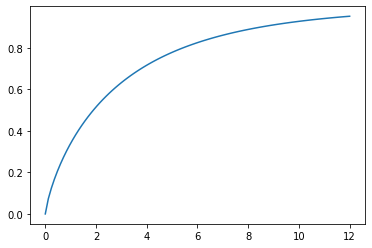

In [6]:
qs = np.linspace(0, 12, 101)
ps = actual_dist.cdf(qs)
cdf = Cdf(ps, qs)
cdf.plot()

Given the parameters, we can generate a random dataset, like this.

In [7]:
np.random.seed(17)
data = actual_dist.rvs(10)
data

array([0.80497283, 2.11577082, 0.43308797, 0.10862644, 5.17334866,
       3.25745053, 3.05555883, 2.47401062, 0.05340806, 1.08386395])

Now let's see if we can go the other way: given the data, we'll estimate the parameters.

Here's a uniform prior distribution for $\lambda$:

In [8]:
lams = np.linspace(0.1, 10, 101)
prior_lam = Pmf(1, lams)
prior_lam.index.name = 'lambda'
prior_lam.normalize()

101

And a uniform prior for $k$:

In [9]:
ks = np.linspace(0.1, 5, 101)
prior_k = Pmf(1, ks)
prior_k.index.name = 'k'
prior_k.normalize()

101

As we've see before, I'll use `make_joint` to make a joint prior distribution for the two parameters.

In [10]:
def make_joint(s1, s2):
    """Compute the outer product of two Series.
    
    First Series across the columns;
    second goes goes down the rows.
    
    s1: Series
    s2: Series
    
    return: DataFrame
    """
    X, Y = np.meshgrid(s1, s2)
    return pd.DataFrame(X*Y, columns=s1.index, index=s2.index)

In [11]:
prior = make_joint(prior_lam, prior_k)

Now I'll use `meshgrid` to make a 3-D mesh with $\lambda$ on the first axis (numbered `axis=0`), $k$ on the second axis (`axis=1`), and the data on the third axis (`axis=2`).

In [12]:
lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)

Now we can use `weibull_dist` to compute the PDF of the Weibull distribution for each pair of parameters and each data point.

In [13]:
densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)
densities.shape

(101, 101, 10)

The likelihood of the data is the product of the probability densities along `axis=2`, which is the axis of the dataset.

In [14]:
likelihood = densities.prod(axis=2)
likelihood.sum()

2.1579134255822728e-05

Now we can compute the posterior distribution in the usual way.

In [15]:
from utils import normalize

posterior = prior * likelihood
normalize(posterior)

The following function encapsulates these steps.  
It takes a joint prior distribution and the data, and returns a joint posterior distribution.

In [16]:
from utils import normalize

def update_weibull(prior, data):
    """Update the prior based on data.
    
    prior: joint distribution of mu and sigma
    data: sequence of observations
    """
    lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

Here's how we use it.

In [17]:
posterior = update_weibull(prior, data)

I'll use `plot_contour` to display the results.

In [18]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

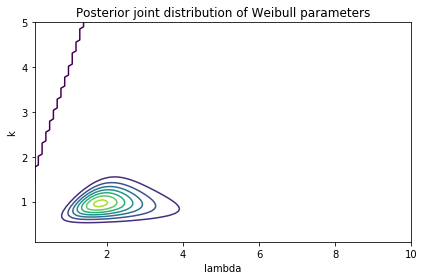

In [19]:
plot_contour(posterior)
decorate(title='Posterior joint distribution of Weibull parameters')
savefig('fig12-01')

The blob in the lower left contains almost all of the probability density; the jaggy line in the upper left is an irrelevent boundary between regions of very low probability.

It looks like the range of likely values for $\lambda$ is about 1 to 4, which contains the actual value we used to generate the data, 3.
And the range for $k$ is about 0.5 to 1.5, which contains the actual value, 0.8.

## Marginal distributions

To be more precise about these ranges, we can extract the marginal distributions:

In [20]:
from utils import marginal

posterior_lam = marginal(posterior, 0)
posterior_k = marginal(posterior, 1)

And compute the posterior means and 90% credible intervals.

(2.406081938305909, array([1.189, 4.357]))

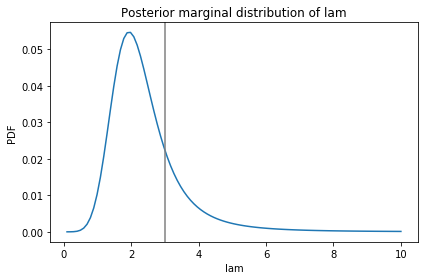

In [21]:
posterior_lam.plot()
plt.axvline(3, color='gray')
decorate(xlabel='lam',
         ylabel='PDF', 
         title='Posterior marginal distribution of lam')

posterior_lam.mean(), posterior_lam.credible_interval(0.9)

The vertical gray line show the actual value of $\lambda$.

(0.9640523544883197, array([0.59 , 1.423]))

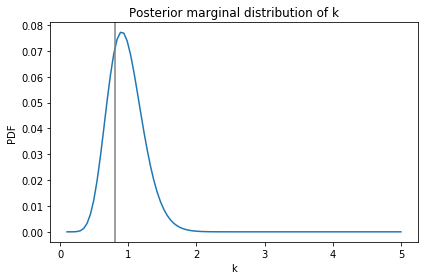

In [22]:
posterior_k.plot()
plt.axvline(0.8, color='gray')
decorate(xlabel='k',
         ylabel='PDF', 
         title='Posterior marginal distribution of k')

posterior_k.mean(), posterior_k.credible_interval(0.9)

The posterior distributions are wide, which means that with only 10 data points we can't estimated the parameters precisely.
But for both parameters, the actual value falls in the credible interval.

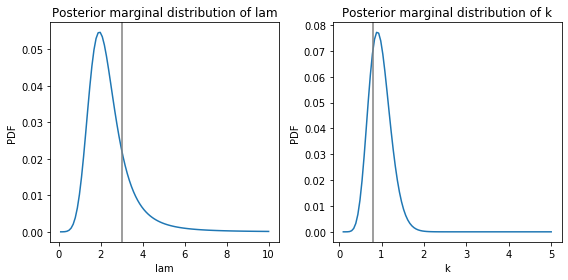

In [23]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
posterior_lam.plot()
plt.axvline(3, color='gray')
decorate(xlabel='lam',
         ylabel='PDF', 
         title='Posterior marginal distribution of lam')

plt.subplot(1, 2, 2)
posterior_k.plot()
plt.axvline(0.8, color='gray')
decorate(xlabel='k',
         ylabel='PDF', 
         title='Posterior marginal distribution of k')

savefig('fig12-02')

## Incomplete data

In the previous example we were given 10 random values from a Weibull distribution, and we used them to estimate the parameters (which we pretended we didn't know).

But in many real-world scenarios, we don't have complete data; in particular, when we observe a system at a point in time, we generally have information about the past, but not the future.

As an example, suppose you work at a dog shelter and you are interested in the time between the arrival of a new dog and when it is adopted.
Some dogs might be snapped up immediately; others might have to wait longer.
The people who operate the shelter might want to make inferences about the distribution of these residence times.

Suppose you monitor arrivals and departures over a 8 weeks, and 10 dogs arrive during that period.
I'll assume that their arrival times are distributed uniformly, so I'll generate random values like this.

In [24]:
np.random.seed(19)
start = np.random.uniform(0, 8, size=10)
start.mean()

3.8042181089023757

Now let's suppose that the dataset we generated in the previous section contains the residence times of the 10 dogs in weeks.
We can use it to construct a `DataFrame` that contains the arrival time and departure time for each dog, `start` and `end`.
And I'll add a third column, `status`, which indicates whether the dog has been adopted.

In [25]:
obs = pd.DataFrame()

obs['start'] = start
obs['end'] = start + data
obs['status'] = 1

obs = obs.sort_values(by='start', ignore_index=True)
obs

,start,end,status
0,0.663997,3.921447,1
1,0.780269,1.585242,1
2,1.105053,1.213680,1
3,1.975504,2.408592,1
4,2.651573,7.824921,1
5,5.085286,6.169150,1
6,5.375817,8.431375,1
7,6.089998,8.205769,1
8,6.452750,8.926761,1
9,7.861935,7.915343,1


I'll use the following function to plot a "lifeline" for each dog, showing the arrival and departure times on a time line.

In [26]:
def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    for y, row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']
        
        if status == 0:
            # ongoing
            plt.hlines(y, start, end, color='C0')
        else:
            # complete
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')
            
    decorate(xlabel='Time (weeks)',
             ylabel='Dog index')

    plt.gca().invert_yaxis()

And here's what it looks like for the data we just generated.

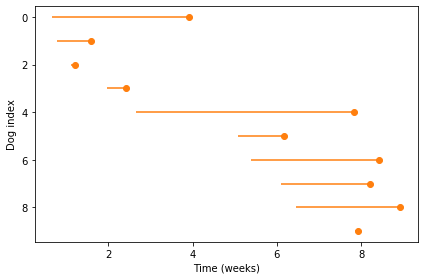

In [27]:
plot_lifelines(obs)

The start times are disributed uniformly, but the lengths of the lines are highly variable.  For example, Dog 2 was adopted almost immediately; Dog 4 had to wait more than 5 weeks.

But notice that several of the lifelines extend past the observation window of 8 weeks.
So if we observed this system at the beginning of Week 8, we would have incomplete information.
Specifically, we would not know the future adoption times for Dogs 6, 7, and 8.

I'll simulate this incomplete data by identifying the lifelines that extend past the observation window:

In [28]:
obs2 = obs.copy()
censored = obs2['end'] > 8

`censored` is a  Boolean Series that is `True` for lifelines that extend past Week 8.

Data that is not available is sometimes called "censored" in the sense that it is hidden from us.
But in this case it is hidden because we don't know the future, not because someone is censoring it.

For the lifelines that are censored, I'll modify `end` to indicate when they are last observed and `status` to indicate that the observation is incomplete. 

In [29]:
obs2.loc[censored, 'end'] = 8
obs2.loc[censored, 'status'] = 0

And we can plot the results to show both complete and incomplete lifelines.

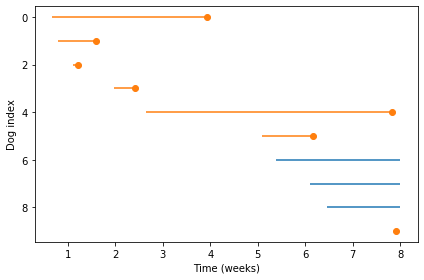

In [30]:
plot_lifelines(obs2)

And I'll add one more column to the table, which contains the duration of the observed parts of the lifelines.

In [31]:
obs2['T'] = obs2['end'] - obs2['start']
obs2

,start,end,status,T
0,0.663997,3.921447,1,3.257451
1,0.780269,1.585242,1,0.804973
2,1.105053,1.213680,1,0.108626
3,1.975504,2.408592,1,0.433088
4,2.651573,7.824921,1,5.173349
5,5.085286,6.169150,1,1.083864
6,5.375817,8.000000,0,2.624183
7,6.089998,8.000000,0,1.910002
8,6.452750,8.000000,0,1.547250
9,7.861935,7.915343,1,0.053408


What we have simulated is the data that would be available at the beginning of Week 8.

## Using incomplete data

Now, let's see how we can use both kinds of data, complete and incomplete, to infer the parameters of the distribution of residence times.

First I'll split the data into two sets: `data1` contains residence times for dogs whose arrival and departure times are known; `data2` contains incomplete residence times for dogs who were not adopted during the observation interval.

In [32]:
complete = obs2['status'] == 1
data1 = obs2.loc[complete, 'T']
data1

0    3.257451
1    0.804973
2    0.108626
3    0.433088
4    5.173349
5    1.083864
9    0.053408
Name: T, dtype: float64

In [33]:
data2 = obs2.loc[~complete, 'T']
data2

6    2.624183
7    1.910002
8    1.547250
Name: T, dtype: float64

For the complete data, we can use `update_weibull`, which uses the PDF of the Weibull distribution to compute the likelihood of the data.

In [34]:
posterior1 = update_weibull(prior, data1)

For the incomplete data, we have to think a little harder.
At the end of the observation interval, we don't know what the residence time will be, but we can put a lower bound on it; that is, we can say that the residence time will be greater than `T`.

And that means that we can compute the likelihood of the data using the survival function, which is the probability that a value from the distribution exceeds `T`.

The following function is identical to `update_weibull` except that it uses `sf`, which computes the survival function, rather than `pdf`.

In [35]:
from utils import normalize

def update_weibull_incomplete(prior, data):
    """Update the prior based on data.
    
    prior: joint distribution of mu and sigma
    data: sequence of observations
    """
    lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    densities = weibull_dist(lam_mesh, k_mesh).sf(data_mesh)
    likelihood = densities.prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

Here's the update with the incomplete data.

In [36]:
posterior2 = update_weibull_incomplete(posterior1, data2)

And here's what the joint posterior distribution looks like after both updates.

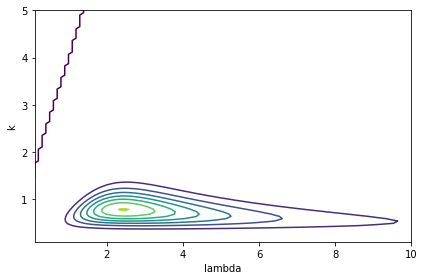

In [37]:
plot_contour(posterior2)

savefig('fig12-03')

Compared to the previous contour plot, it looks like the range of likely values for $\lambda$ is substantially wider.
We can see that more clearly by looking at the marginal distributions.

In [38]:
posterior_lam2 = marginal(posterior2, 0)
posterior_k2 = marginal(posterior2, 1)

Here's the posterior marginal distribution for $\lambda$ compared to the distribution we got using all complete data.

(2.406081938305909, array([1.189, 4.357]))

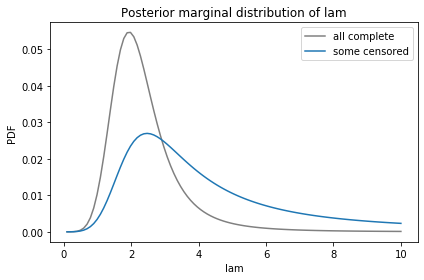

In [39]:
posterior_lam.plot(color='gray', label='all complete')
posterior_lam2.plot(label='some censored')

decorate(xlabel='lam',
         ylabel='PDF', 
         title='Posterior marginal distribution of lam')

posterior_lam.mean(), posterior_lam.credible_interval(0.9)

Visually, the distribution with some incomplete data is substantially wider, and the 90% credible interval is wider, too.

As an aside, notice that the posterior distribution does not come all the way to 0 on the right side.
That suggests that the range of the prior distribution is not wide enough to cover the most likely values for this parameter.
If I were concerned about making this distribution more accurate, I would go back and run the update again with a wider prior.

Here's the posterior marginal distribution for $k$:

(0.9640523544883197, array([0.59 , 1.423]))

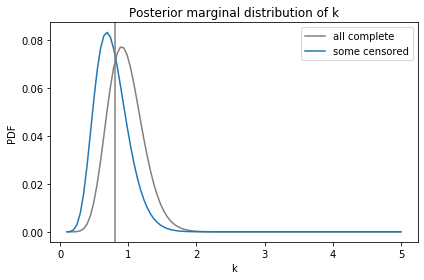

In [40]:
posterior_k.plot(color='gray', label='all complete')
posterior_k2.plot(label='some censored')

plt.axvline(0.8, color='gray')
decorate(xlabel='k',
         ylabel='PDF', 
         title='Posterior marginal distribution of k')

posterior_k.mean(), posterior_k.credible_interval(0.9)

In this example, the marginal distribution is shifted to the left when we have incomplete data, but it is not substantially wider.

In summary, we have seen how to combine complete and incomplete data to estimate the parameters of a Weibull distribution, which is useful in many real-world scenarios where some of the data are censored.

In general, the posterior distributions are wider when we have incomplete data, because less information leads to more uncertainty.

This example is based on data I generated; in the next section we'll do a similar analysis with real data.

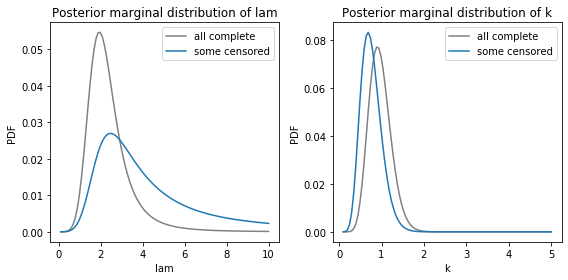

In [41]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
posterior_lam.plot(color='gray', label='all complete')
posterior_lam2.plot(label='some censored')
decorate(xlabel='lam',
         ylabel='PDF', 
         title='Posterior marginal distribution of lam')

plt.subplot(1, 2, 2)
posterior_k.plot(color='gray', label='all complete')
posterior_k2.plot(label='some censored')
decorate(xlabel='k',
         ylabel='PDF', 
         title='Posterior marginal distribution of k')

savefig('fig12-04')

## Lightbulbs

In 2007 [researchers ran an experiment](https://www.researchgate.net/publication/225450325_Renewal_Rate_of_Filament_Lamps_Theory_and_Experiment) to characterize the distribution of lifetimes for lightbulbs.

Here is their description of the experiment:

> An assembly of 50 new Philips (India) lamps with the rating 40 W, 220 V (AC) was taken and installed in the horizontal orientation and uniformly distributed over a lab area 11 m x 7 m.
>
> The assembly was monitored at regular intervals of 12 h to look for failures. The instants of recorded failures were [recorded] and a total of 32 data points were obtained such that even the last bulb failed. 

The data were reported in the following columns:

```
i - observation number
h - time in hours since experiment start
f - number of failed lamps at particular time h
K - number of surviving lamps  at particular time h
```

We can download the data here:

In [42]:
# Load the data file

datafile = 'lamps.csv'
if not os.path.exists(datafile):
    !wget https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv

And load it into a `DataFrame` like this:

In [43]:
df = pd.read_csv('lamps.csv', index_col=0)
df.head()

,h,f,K
i,,,
0,0,0,50
1,840,2,48
2,852,1,47
3,936,1,46
4,960,1,45


Column `h` contains the time values when bulbs failed; Column `f` contains the number of bulbs that failed at each time.
We can represent these values and frequencies using a `Pmf`, like this:

In [44]:
pmf_bulb = Pmf(df['f'].to_numpy(), df['h'])
pmf_bulb.normalize()

50

Because of the design of this experiment, we can consider the data to be a representative sample from the distribution of lifetimes, at least for light bulbs that are lit continuously.

The average lifetime is about 1400 h.

In [45]:
pmf_bulb.mean()

1413.84

Here's what the distribution looks like.
I'll plot the CDF of the data along with the CDF of a Weibull distribution I chose to fit the data.

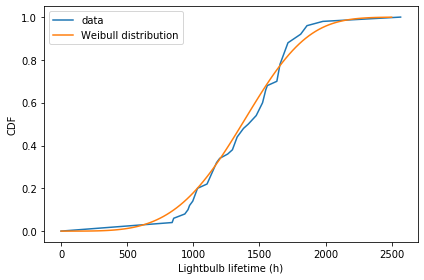

In [46]:
pmf_bulb.make_cdf().plot(label='data')

qs = np.linspace(0, 2500, 101)
ps = weibull_dist(1500, 4).cdf(qs)
cdf = Cdf(ps, qs)
cdf.plot(label='Weibull distribution')

decorate(xlabel='Lightbulb lifetime (h)',
         ylabel='CDF')

It looks like the Weibull distribution is a good model for the data.
So we should be able to use the data to infer the parameters of the model.

Again, I'll start with uniform priors for $\lambda$ and $k$:

In [47]:
lams = np.linspace(1000, 2000, 51)
prior_lam = Pmf(1, lams)
prior_lam.index.name = 'lambda'
prior_lam.normalize()

51

In [48]:
ks = np.linspace(1, 10, 51)
prior_k = Pmf(1, ks)
prior_k.index.name = 'k'
prior_k.normalize()

51

For this example, there are 51 values in the prior distribtion, rather than the usual 101.  That's because we are going to use the posterior distributions to do some computationally-intensive calculations.
They will run faster with fewer values, but the results will be less precise.

As usual, we can use `make_joint` to make the prior joint distribution.

In [49]:
prior_bulb = make_joint(prior_lam, prior_k)

Although we have data for 50 lightbulbs, there are only 32 unique lifetimes in the dataset.  For the update, it is convenient to express the data in the form of 50 lifetimes, with each lifetime repeated the given number of times.
We can use `np.repeat` to transform the data.

In [50]:
data_bulb = np.repeat(df['h'], df['f'])
len(data_bulb)

50

Now we can use `update_weibull` to do the update.

In [51]:
posterior_bulb = update_weibull(prior_bulb, data_bulb)

Here's what the posterior joint distribution looks like:

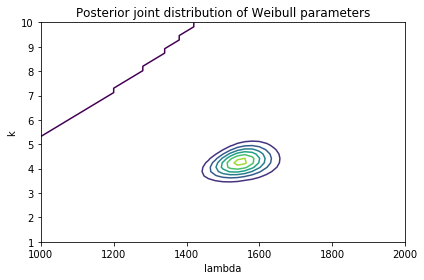

In [52]:
plot_contour(posterior_bulb)
decorate(title='Posterior joint distribution of Weibull parameters')

But that's not quite right, because it assumes each lightbulb died at the instant we observed it.  But apparently the researchers only checked the bulbs every 12 hours.  So if they see that a bulb has died, they know only that it died during the 12 hours since the last check.

So it is more strictly correct to use the following update function, which uses the CDF of the Weibull distribution to compute the probability that a bulb dies during a given 12 hour interval.

In [53]:
def update_weibull_between(prior, data, dt=12):
    """Update the prior based on data.
    
    prior: joint distribution of mu and sigma
    data: sequence of observations
    """
    lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    dist = weibull_dist(lam_mesh, k_mesh)
    cdf1 = dist.cdf(data_mesh)
    cdf2 = dist.cdf(data_mesh-12)
    likelihood = (cdf1 - cdf2).prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

The probability that a value falls in an interval is the difference between the CDF at the beginning and end.

Here's how we run the update.

In [54]:
posterior_bulb2 = update_weibull_between(prior_bulb, data_bulb)

And here are the results.

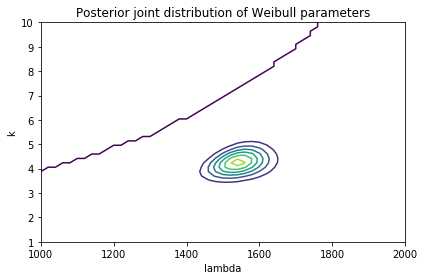

In [55]:
plot_contour(posterior_bulb2)
decorate(title='Posterior joint distribution of Weibull parameters')

Visually this result is almost identical to what we got using the PDF.
And that's good news, because it suggests that using the PDF can be a good approximation even if it's not strictly correct.

To see whether it makes any difference at all, let's check the posterior means.

## Posterior means

To compute the posterior mean of the joint distribution we can enumerate the parameters and their probabilities.
For each pair of parameters, $\lambda$ and $k$, we use `weibull_dist` to compute the mean, which is

$\lambda \, \Gamma(1+1/k)$

where $\Gamma$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function).

Then, using the probabilities as weights, we add up the total posterior mean.

In [56]:
def joint_weibull_mean(joint):
    """Compute the mean of a joint distribution of Weibulls.
    
    joint: DataFrame of Weibull parameters and probabilities
    
    returns: expected mean value
    """
    pmf = Pmf(joint.stack())
    total = 0
    for (k, lam), prob in pmf.items():
        mean = weibull_dist(lam, k).mean()
        total += prob * mean
    return total

Here are the means of the two posterior distributions: 

In [57]:
joint_weibull_mean(posterior_bulb)

1412.724277430501

In [58]:
joint_weibull_mean(posterior_bulb2)

1406.8171982320873

When we take into account the 12 hour interval between observations, the posterior mean is about 6 hours less.
If we assume that a bulb is equally likely to expire at any point in the interval, which is at least approximately true, the 6 hour difference makes sense.

As the number of elements in the joint distribution increases, it can become expensive to enumerate all pairs of parameters.
An alternative is to draw a random sample from the joint distribution, using the probabilities of weights.
As an example, I'll use random sampling to estimate the posterior mean we just computed.

As in `joint_weibull_mean`, we'll start by stacking the joint distribution.

In [59]:
posterior_pmf = Pmf(posterior_bulb2.stack())
posterior_pmf

k     lambda
1.0   1000.0    1.080654e-24
      1020.0    1.596253e-24
      1040.0    2.279356e-24
      1060.0    3.153589e-24
      1080.0    4.236317e-24
                    ...     
10.0  1920.0    9.697504e-36
      1940.0    6.517344e-37
      1960.0    3.541780e-38
      1980.0    1.603116e-39
      2000.0    6.201824e-41
Length: 2601, dtype: float64

The result is a `Pmf` with a `MultiIndex` that contains the parameters.
If we reset the index, the parameters become named columns, and the probabilities are put in a column with the label `0`.

In [60]:
reset = posterior_pmf.reset_index()
reset.head()

,k,lambda,0
0,1.0,1000.0,1.080654e-24
1,1.0,1020.0,1.596253e-24
2,1.0,1040.0,2.279356e-24
3,1.0,1060.0,3.153589e-24
4,1.0,1080.0,4.236317e-24


The new index contains integers starting from 0. 
We can use `np.random.choice` to choose random labels from the new index, weighted with the probabilities from the `Pmf`.

In [61]:
index = np.random.choice(reset.index, p=posterior_pmf, size=1000)

In [62]:
chosen = reset.loc[index]
chosen.head()

,k,lambda,0
843,3.88,1540.0,0.016875
947,4.24,1580.0,0.019609
947,4.24,1580.0,0.019609
844,3.88,1560.0,0.014567
792,3.70,1540.0,0.010069


The result is a `DataFrame` with the chosen rows.
Now we can select the parameters, pass them to `weibull_dist`, and use `rvs` to choose one value from each distribution specified by a pair of parameters. 

In [63]:
sample = weibull_dist(chosen['lambda'], chosen['k']).rvs()

The result is a sample from the posterior predictive distribution, which we can use to compute whatever summary statistics we are interested in, including the mean:

In [64]:
sample.mean()

1409.0297180847385

Here are those steps encapsulated in a function.

In [65]:
def joint_weibull_sample(joint, n=1000):
    """Sample from a predictive distribution.
    
    joint: joint distribution of parameters
    n: sample size
    
    returns: NumPy array of random values
    """
    pmf = Pmf(joint.stack())
    reset = pmf.reset_index()
    index = np.random.choice(reset.index, p=pmf, size=n)
    chosen = reset.loc[index]
    sample = weibull_dist(chosen['lambda'], chosen['k']).rvs()
    return sample

And here's how we can use it.

In [66]:
sample = joint_weibull_sample(posterior_bulb2)
sample.mean()

1422.2688171419734

As one of the exercises at the end of this chapter, you can write a similar function for the gamma distribution.

## Summary

This chapter introduces survival analysis, which is use to answer questions about the time until an event, and the Weibull distribution, which is a good model for "lieftimes", broadly interpreted, in a number of domains.

We used joint distributions to represent prior probabilities for the parameters of the Weibull distribution, and we updated them three ways: knowing the exact duration of a lifetime, knowing a lower bound, and knowing that a lifetime fell in a given interval.

These examples demonstrate a feature of Bayesian methods: they can be adapted to handle incomplete, or "censored", data with only small changes.  As an exercise, you'll have a chance to work with one more type of censored data, when we are given an upper bound on a lifetime.

The methods in this chapter work with any distribution with two parameters.  In the exercises, you'll have a chance to estimate the parameters of a gamma distribution, which is used to describe a variety of natural phenomena.

And in the next chapter we'll move on to models with three parameters, which we will use to do Bayesian regression.

## Exercises

**Exercise:** Suppose you install 100 lightbulbs of the kind we studied in this chapter, and you come back to check on them after 1000 hours.  Based on the posterior distribution we just computed, how many lightbulbs do you expect to be dead?  What is the distribution of this number?

Hint: Use `make_binomial` and `make_mixture` to compute the posterior predictive distribution for the number of dead bulbs.

Note: This calculation involves a substantial amount of computation, which is why I made the grid in this chapter coarser than in previous chapters, with 51 values for each parameter rather than 101.

In [79]:
from utils import make_binomial, make_mixture

In [80]:
# Solution

posterior_pmf = Pmf(posterior_bulb2.stack())

In [81]:
# Solution

t = 1000

total = 0
for (k, lam), prob in posterior_pmf.items():
    prob_dead = weibull_dist(lam, k).cdf(t)
    total += prob * prob_dead

In [82]:
# Solution

n = 100
total * n

14.945401430072334

In [83]:
# Solution

pmf_seq = []
for (k, lam), prob in posterior_pmf.items():
    prob_dead = weibull_dist(lam, k).cdf(t)
    pmf = make_binomial(n, prob_dead)
    pmf_seq.append(pmf)

In [84]:
# Solution

pred = make_mixture(posterior_pmf, pmf_seq)

14.945401430072216

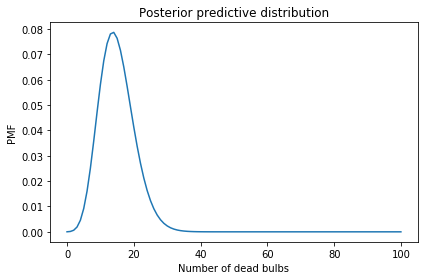

In [85]:
# Solution

pred.plot()
decorate(xlabel='Number of dead bulbs',
         ylabel='PMF',
         title='Posterior predictive distribution')

pred.mean()

**Exercise:** Now suppose that when you come back after 1000 hours, you actually find 20 dead lightbulbs.  Update the posterior distribution based on this data.  How much does it change the posterior mean?

In [89]:
# Solution

t = 1000

lam_mesh, k_mesh = np.meshgrid(prior_bulb.columns, prior_bulb.index)
prob_dead = weibull_dist(lam_mesh, k_mesh).cdf(t)
prob_dead.shape

(51, 51)

In [90]:
# Solution

from scipy.stats import binom

k = 20
n = 100
likelihood = binom.pmf(k, n, prob_dead)
likelihood.shape

(51, 51)

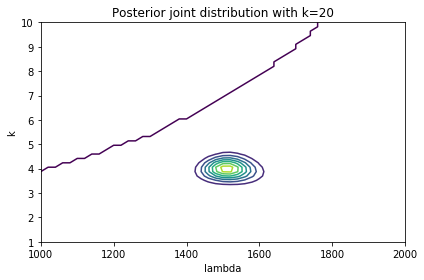

In [91]:
# Solution

posterior_bulb3 = posterior_bulb2 * likelihood
normalize(posterior_bulb3)
plot_contour(posterior_bulb3)
decorate(title='Posterior joint distribution with k=20')

In [93]:
# Solution

# Since there were more dead bulbs than expected,
# the posterior mean is a bit less after the update.

joint_weibull_mean(posterior_bulb3)

1374.6787666856153

**Exercise:** According to hydrologists, the distribution of total daily
rainfall (for days with rain) is well modeled by a two-parameter
gamma distribution.

In this exercise, we'll use one month of data to estimate the parameters of a gamma distribution that describes daily rainfall in Seattle.
Then we'll compute the posterior predictive distribution for daily rainfall, including the possibility of no rain.

The following cell downloads data I collected from the National Oceanic and Atmospheric Administration ([NOAA](http://www.ncdc.noaa.gov/cdo-web/search)) for Seattle, Washington in May 2020.

In [94]:
# Load the data file

datafile = '2203951.csv'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2203951.csv

Now we can load it into a `DataFrame`:

In [95]:
weather = pd.read_csv('2203951.csv')
weather.head()

,STATION,NAME,DATE,AWND,PRCP,TMAX,TMIN,WT01,WT03,WT08
0,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-01,4.47,0.00,66,43,NaN,NaN,NaN
1,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-02,9.40,0.24,58,47,1.0,NaN,NaN
2,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-03,11.63,0.06,57,44,1.0,NaN,NaN
3,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-04,4.47,0.00,65,39,NaN,NaN,NaN
4,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-05,7.83,0.00,71,49,NaN,NaN,NaN


I'll make a Boolean Series to indicate which days it rained.

In [96]:
rained = weather['PRCP'] > 0
rained.sum()

14

And select the total rainfall on the days it rained.

In [97]:
prcp = weather.loc[rained, 'PRCP']
prcp.describe()

count    14.000000
mean      0.222857
std       0.301060
min       0.010000
25%       0.052500
50%       0.110000
75%       0.225000
max       1.140000
Name: PRCP, dtype: float64

Here's what the CDF of the data looks like.

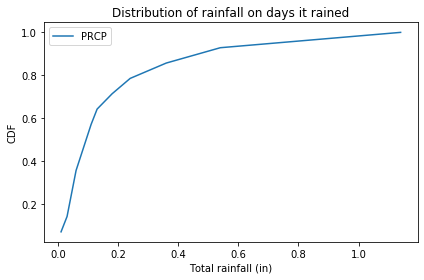

In [98]:
cdf_data = Cdf.from_seq(prcp)
cdf_data.plot()
decorate(xlabel='Total rainfall (in)',
         ylabel='CDF',
         title='Distribution of rainfall on days it rained')

Now I suggest you proceed in the following steps:

1. Construct a prior distribution for the parameters of the gamma distribution.

2. Use the observed rainfalls to update the distribution of parameters.

3. Generate a sample of 1000 values from the posterior predictive distribution.  This is the distribution of rainfall we expect on the days it rains.

4. Then, to estimate the probability of rain.



For the first step, you might want to use the following function, which creates an object that represents a gamma distribution a shape parameter, $k$, and
a scale parameter, $\theta$.

The result is an object that provides methods `pdf`, `cdf`, and `sf` that compute the PDF, CDF, and survival function, as well as `rvs`, which generates random values.

In [99]:
import scipy.stats

def gamma_dist(k, theta):
    """Makes a gamma object.
    """
    return scipy.stats.gamma(k, scale=theta)

For Step 4, you might want to use the following function from Chapter 6, which you can use to compute the posterior distribution for the probability of rain.

In [100]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update the PMF using the binomial distribution.
    
    pmf: Pmf representing the prior
    data: tuple of integers k and n
    """
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

Now you take it from there.

In [101]:
# Solution

ks = np.linspace(0.01, 2, 101)
prior_k = Pmf(1, ks)
prior_k.index.name = 'k'
prior_k.normalize()

101

In [102]:
# Solution

thetas = np.linspace(0.01, 1.5, 101)
prior_theta = Pmf(1, thetas)
prior_theta.index.name = 'theta'
prior_theta.normalize()

101

In [103]:
# Solution

prior = make_joint(prior_k, prior_theta)

In [104]:
# Solution

k_mesh, theta_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, prcp)

In [105]:
# Solution

densities = gamma_dist(k_mesh, theta_mesh).pdf(data_mesh) 
densities.shape

(101, 101, 14)

In [106]:
# Solution

likelihood = densities.prod(axis=2)
likelihood.sum()

601019.972665461

In [107]:
# Solution

posterior = prior * likelihood
normalize(posterior)

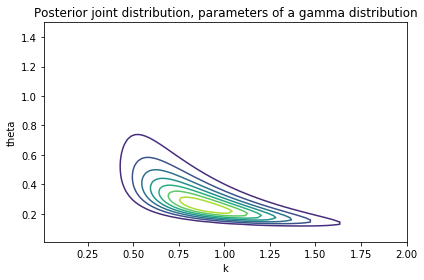

In [108]:
# Solution

plot_contour(posterior)

decorate(title='Posterior joint distribution, parameters of a gamma distribution')

In [109]:
# Solution

from utils import marginal

posterior_k = marginal(posterior, 0)
posterior_theta = marginal(posterior, 1)

(0.84368972214469, array([0.4478, 1.3632]))

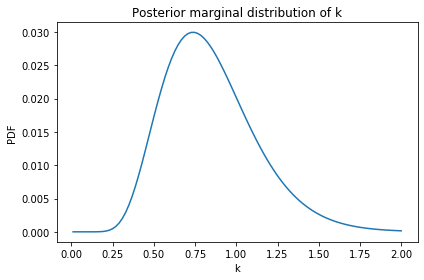

In [110]:
# Solution

posterior_k.plot()
decorate(xlabel='k',
         ylabel='PDF', 
         title='Posterior marginal distribution of k')

posterior_k.mean(), posterior_k.credible_interval(0.9)

(0.3676197943125124, array([0.159 , 0.7997]))

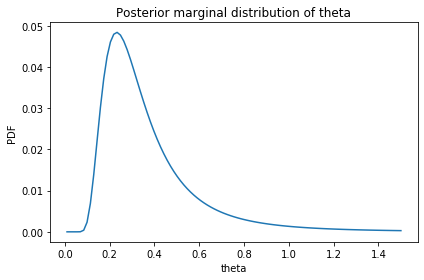

In [111]:
# Solution

posterior_theta.plot()
decorate(xlabel='theta',
         ylabel='PDF', 
         title='Posterior marginal distribution of theta')

posterior_theta.mean(), posterior_theta.credible_interval(0.9)

In [112]:
# Solution

def joint_gamma_sample(joint, n=1000):
    """Sample from a predictive distribution.
    
    joint: joint distribution of parameters
    n: sample size
    
    returns: NumPy array of random values
    """
    pmf = Pmf(joint.stack())
    reset = pmf.reset_index()
    index = np.random.choice(reset.index, p=pmf, size=n)
    chosen = reset.loc[index]
    sample = gamma_dist(chosen['k'], chosen['theta']).rvs()
    return sample

In [113]:
# Solution

sample = joint_gamma_sample(posterior)

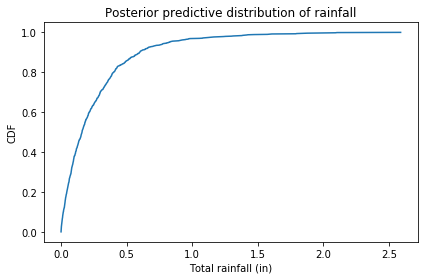

In [114]:
# Solution

Cdf.from_seq(sample).plot()
decorate(xlabel='Total rainfall (in)',
         ylabel='CDF',
         title='Posterior predictive distribution of rainfall')

In [115]:
# Solution

# Now let's estimate the probability of rain

data = rained.sum(), len(weather)
data

(14, 31)

In [116]:
# Solution

# Here's the prior and the update

hypos = np.linspace(0, 1, 101)
pmf_rain = Pmf(1, hypos)
update_binomial(pmf_rain, data)

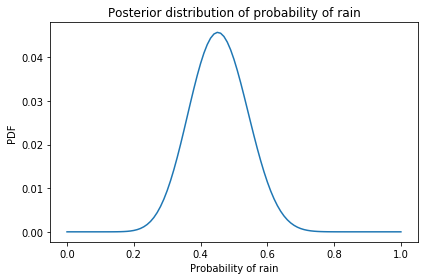

In [117]:
# Solution

# And the posterior

pmf_rain.plot()
decorate(xlabel='Probability of rain',
         ylabel='PDF',
         title='Posterior distribution of probability of rain')

In [118]:
# Solution

# For prediction, we only need the posterior mean

p_rain = pmf_rain.mean()
p_rain

0.4545454545454545

In [119]:
# Solution

# Here's a predictive sample for which days it rains

rained = np.random.random(len(sample)) < p_rain
rained.mean()

0.465

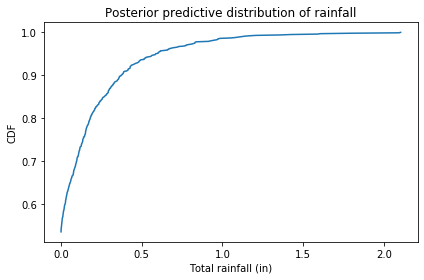

In [120]:
# Solution

# Now to simulate rain days and non-rain days, we can
# multiplytotal rainfall by Boolean True/False values,
# which are treated as 1/0

pred = rained * sample
Cdf.from_seq(pred).plot()

decorate(xlabel='Total rainfall (in)',
         ylabel='CDF',
         title='Posterior predictive distribution of rainfall')